# Robust training with MOM on PyTorch

In [34]:
import os
import torch
import torch.nn as nn
import numpy as np
import numpy.random as alea
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from random import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import progressbar
import momAPI.nn.indexed_dataset as indexed_dataset
import momAPI.nn.utilities as utilities
import momAPI.nn.MOM_training as MOM_training
import momAPI.nn.MOM_sampler as MOM_sampler
import momAPI.nn.classical_nn_training as class_train
from math import log
import seaborn as sns

In [35]:
plt.style.use('seaborn-darkgrid')
random_seed = 7
alea.seed(random_seed)

### Test on custom model

Let $U_1,U_2$ be stochastic function, and $Y = \sigma(U_1)\sigma(2U_2)$, we want to predict Y knowing $U_1$ and $U_2$ but there are outliers in the data.

In [52]:
n_obs = 2000
n_outliers = 60

U1 = np.random.normal(0,1,n_obs)
U2 = np.random.normal(0,1,n_obs)

U1_test = np.random.normal(0,1,n_obs)
U2_test = np.random.normal(0,1,n_obs)

outliers_pos = np.random.randint(0, n_obs, n_outliers)

U_test = torch.FloatTensor(np.vstack((U1_test,U2_test)).transpose())
U = torch.FloatTensor(np.vstack((U1,U2)).transpose())

U1, U2 = torch.FloatTensor(U1), torch.FloatTensor(U2)
U1_test, U2_test = torch.FloatTensor(U1_test), torch.FloatTensor(U2_test)

Y = torch.sigmoid(U1) * torch.sigmoid(U2)
Y_test = torch.sigmoid(U1_test) * torch.sigmoid(U2_test)

for i in outliers_pos:
    Y[i] = torch.sigmoid(100+torch.randn(1)) * torch.sigmoid(torch.randn(1)+10)

data_train = indexed_dataset.Dataset(U , Y)
data_test = indexed_dataset.Dataset(U_test , Y_test)

In [53]:
class nn(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(nn, self).__init__()

        self.layer = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.layer(x))
        x = x.view(-1)
        return(x)

In [ ]:
nn_ = nn()
optimizer = torch.optim.SGD( nn_.parameters(), lr=1)
loss_ = torch.nn.modules.loss.MSELoss(reduction = 'mean')
MOM_nn = MOM_training.mom_net(nn_ , optimizer , loss_ , random_seed = random_seed, n_epochs = 100 , batch_size = 16, n_hist = 100)
MOM_nn.fit(data_train, data_val = data_test )

In [ ]:
nnbis_ = nn()
optimizerbis = torch.optim.SGD( nnbis_.parameters(), lr=0.1)
loss_ = torch.nn.modules.loss.MSELoss(reduction = 'mean')
classical_nn = class_train.mom_net(nnbis_ , optimizerbis , loss_ , random_seed = random_seed, n_epochs = 100 , batch_size = 16, n_hist = 100)
classical_nn.fit(data_train, data_val = data_test)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


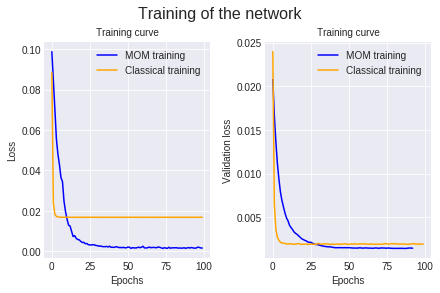

In [65]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Training of the network", fontsize=16)

ax1.plot(MOM_nn.history['loss'] , color = "blue" , label = "MOM training")
ax1.plot(classical_nn.history['loss'] , color = 'orange' , label = "Classical training")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training curve", fontsize=10)

ax2.plot(MOM_nn.history['val_loss'][7:] , color = "blue" , label = "MOM training")
ax2.plot(classical_nn.history['val_loss'] , color = 'orange' , label = "Classical training")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Validation loss")
ax2.set_title("Training curve", fontsize=10)
fig.show()
plt.savefig("training_curve_bis.png")

### The database

We want to classify crocodiles and pionguins extracted from tiny-resnet. In order to check if our training is robust to outliers, we corrupt our dataset with fish photos.

#### Data importation

In [104]:
def rescale(img):
    _,_,channel = img.shape
    tab = np.zeros(img.shape)
    for i in range(channel):
        mini = np.min(img[:,:,i])
        maxi = np.max(img[:,:,i])
        tab[:,:,i] = (img[:,:,i] - mini)/(maxi-mini)
    
    return tab

def plot_torch_img(img):
    
    np_img = img.numpy()
    np_img = np.swapaxes(np_img,0,2)
    plt.imshow(np_img)

In [116]:
images = []
target = []
croc,ping = [],[]
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            if animal == 'crocodile':
                croc.append(rescale(np.array(img)))
            else:
                ping.append(rescale(np.array(img)))
                
            images.append(rescale(np.array(img)))
            target.append([i])
            
    i += 1

outliers_1 = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers_1.append(rescale(np.array(img)))

images_train , images_test , target_train , target_test = train_test_split(images , target ,
                                                                           random_state = random_seed)

In [74]:
hist_croc_R = []
hist_croc_G = []
hist_croc_B = []
hist_ping_R = []
hist_ping_G = []
hist_ping_B = []
hist_fish_R = []
hist_fish_G = []
hist_fish_B = []

for i in croc:
    hist_croc_R.append(np.mean(i[:,:,0]))
    hist_croc_G.append(np.mean(i[:,:,1]))
    hist_croc_B.append(np.mean(i[:,:,2]))

for i in ping:
    hist_ping_R.append(np.mean(i[:,:,0]))
    hist_ping_G.append(np.mean(i[:,:,1]))
    hist_ping_B.append(np.mean(i[:,:,2]))
    
for i in outliers_1:
    hist_fish_R.append(np.mean(i[:,:,0]))
    hist_fish_G.append(np.mean(i[:,:,1]))
    hist_fish_B.append(np.mean(i[:,:,2]))

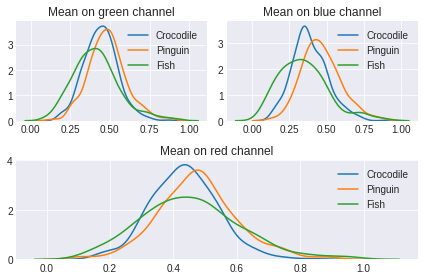

In [103]:
plt.subplot(212)
sns.distplot(hist_croc_R, bins = [i/100 for i in range(100)], hist = False, kde = True, label = "Crocodile")
sns.distplot(hist_ping_R, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Pinguin')
sns.distplot(hist_fish_R, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Fish')
plt.title('Mean on red channel')

plt.subplot(221)
sns.distplot(hist_croc_G, bins = [i/100 for i in range(100)], hist = False, kde = True, label = "Crocodile")
sns.distplot(hist_ping_G, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Pinguin')
sns.distplot(hist_fish_G, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Fish')
plt.title('Mean on green channel')

plt.subplot(222)
sns.distplot(hist_croc_B, bins = [i/100 for i in range(100)], hist = False, kde = True, label = "Crocodile")
sns.distplot(hist_ping_B, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Pinguin')
sns.distplot(hist_fish_B, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Fish')
plt.title('Mean on blue channel')
plt.tight_layout()
plt.savefig("distribution_img.png")

#### Creation of the black and white outliers

In [140]:
n_outliers_2 = 10
outliers_2 = []
target_outliers_2 = []

for i in indexes:
    outliers_2.append(np.ones(images[i].shape)*randint(0,1))
    target_outliers_2.append([randint(0,1)])

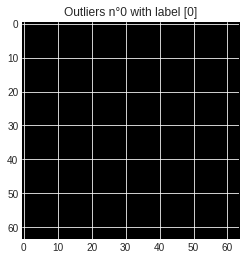

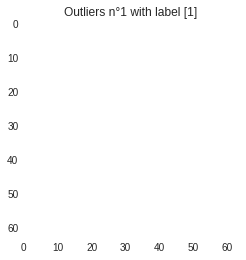

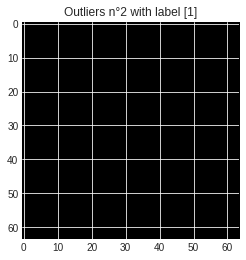

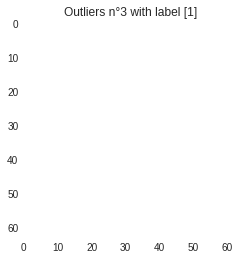

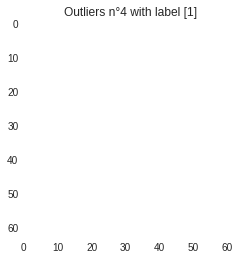

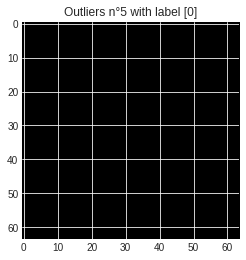

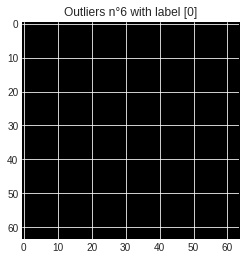

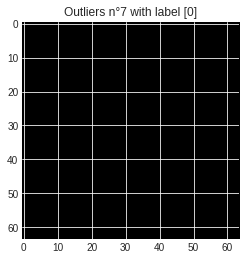

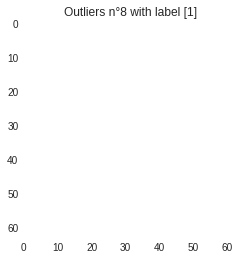

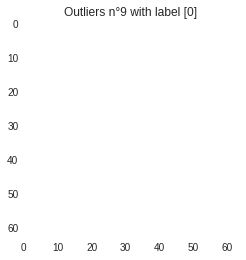

In [178]:
for i,x in enumerate(outliers_2):
    plt.imshow(x)
    plt.title("Outliers n°"+str(i)+" with label "+str(target_outliers_2[i]))
    plt.show()

#### Creation of the fish outliers and the corrupted train set

In [118]:
n_outliers_1 = 0

for i in range(n_outliers_1):
    images_train.append(outliers_1[i])
    target_train.append([randint(0,1)])
    
images_train += outliers_2
target_train += target_outliers_2

target_train = torch.FloatTensor(target_train)
target_test = torch.FloatTensor(target_test)

#### Data transformation

First we create a transformer in order to transform np.array to torch.tensor with the channels in the first dimension.

In [179]:
transformer = transforms.Compose( [ transforms.ToTensor() ])
data_train = indexed_dataset.Dataset(images_train , target_train , transform = transformer)
data_test = indexed_dataset.Dataset(images_test , target_test , transform = transformer)

### The network

For the architecture of my network, I used 3 convolutional layers with Relu activation, each followed by a max pooling layer, in order to extract the best feature. Then I had a dense layer with sigmoid activation in order to do 0/1 classification.

In [180]:
class CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(CNN, self).__init__()
        
        #input channels = 3, output channels = 16
        self.block_1 = torch.nn.Sequential(torch.nn.Conv2d(3 , 32 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(32),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(3))
        
        #Input channels = 16, output channels = 32
        self.block_2 = torch.nn.Sequential(torch.nn.Conv2d(32 , 64 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(64),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #Input channels = 32, output channels = 64
        self.block_3 = torch.nn.Sequential(torch.nn.Conv2d(64 , 128 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(128),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #128 input features, 1 output features for binary classification
        self.fc1 = torch.nn.Linear(1152, 1)
        
        #self.conv_dropout = nn.Dropout2d(p = 0.0)
        self.dense_dropout = torch.nn.Dropout(p = 0.0)
        
    def forward(self, x):
        #print("1:", (x == x).all())
        #Computes the Fivation of the first convolution
        #Size changes from (3, 64, 64) to (32, 20, 20)
        x = self.block_1(x)
        #print(x.size())
        #print("1:", (x == x).all())
        
        #Size changes from (32, 20, 20) to (64, 9, 9)
        x = self.block_2(x)
        #print(x.size())
        #print("2:", (x == x).all())
        
        #Size changes from (64, 9, 9) to (128, 3, 3)
        x = self.block_3(x)
        #print(x.size())
        #print("3:", (x == x).all())
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (128 , 1 , 1) to (,1152)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.size())
        x = x.view(-1,1152)
        
        #Computes the Fivation of the fully connected layer
        #Size changes from (1, 2304) to (1, 1)
        x = torch.sigmoid(self.dense_dropout(self.fc1(x)))
        
        return(x)

### Training

We use Adam optimizer and our loss is the classical binary cross entropy with a logistic loss which can be calculated with the following formula : 
$$ BCE(y,\widehat{y}) = -(ylog(\widehat{y})+(1-y)log(1-\widehat{y}))$$

In [182]:
CNN_ = CNN()
optimizer = torch.optim.Adam( CNN_.parameters(), lr=0.001)
loss_ = torch.nn.modules.loss.BCELoss(reduction = 'mean')

In [ ]:
MOM_CNN = MOM_training.mom_net(CNN_ , optimizer , loss_ , random_seed = random_seed, n_epochs = 250 , batch_size = 16, n_hist = 200)
MOM_CNN.fit(data_train , data_val = data_test, acc = True)
torch.save(MOM_CNN.model.state_dict(), "models/CNN_1")

Training curves

In [185]:
CNN_classic = CNN()
optimizer_classic = torch.optim.SGD( CNN_classic.parameters(), lr=0.01)
loss_classic = torch.nn.modules.loss.BCELoss(reduction = 'mean')
classical_cnn = class_train.mom_net(CNN_classic , optimizer_classic , loss_classic, random_seed = random_seed, n_epochs = 100 , batch_size = 16, n_hist = 100)
classical_cnn.fit(data_train, data_val = data_test, acc = True)

In [59]:
history = MOM_CNN.history
history_class = classical_cnn.history
model = MOM_CNN.model

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


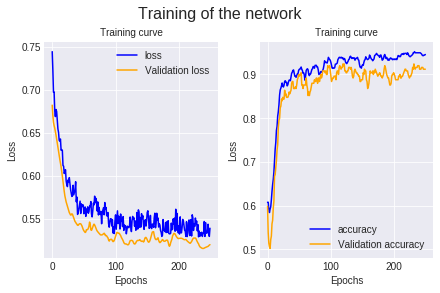

In [63]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Training of the network", fontsize=16)

ax1.plot(history['loss'] , color = "blue" , label = "loss")
ax1.plot(history['val_loss'] , color = 'orange' , label = "Validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training curve", fontsize=10)

ax2.plot(history['acc'] , color = "blue" , label = "accuracy")
ax2.plot(history['val_acc'] , color = 'orange' , label = "Validation accuracy")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training curve", fontsize=10)
fig.show()
plt.savefig("training_curve.png")

#### Outliers detection

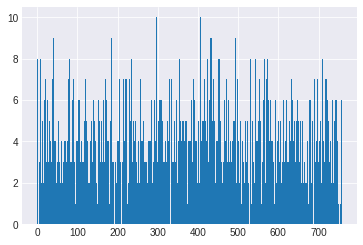

In [143]:
non_outliers = np.unique(MOM_CNN.history['hist'])
freq = plt.hist(MOM_CNN.history['hist'] , bins = np.arange(len(data_train)+1))[0]

In [147]:
outliers = []

for i in range(len(data_train)):
    if i not in non_outliers:
        outliers.append(i)

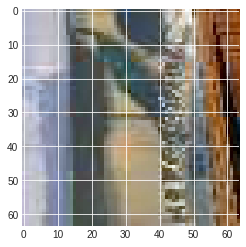

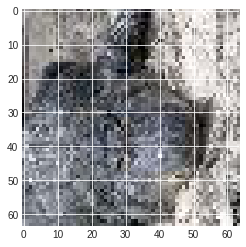

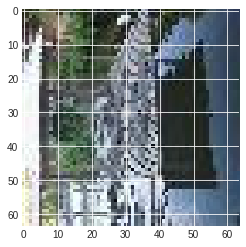

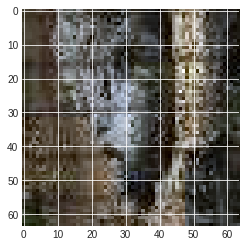

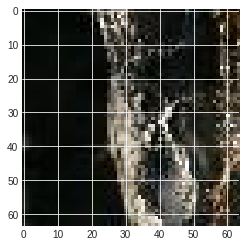

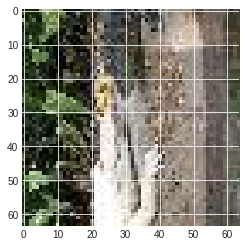

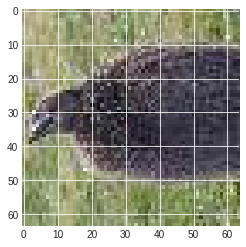

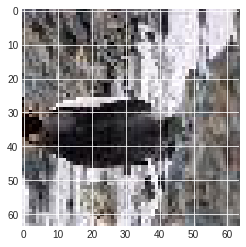

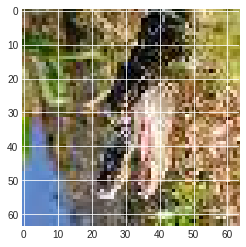

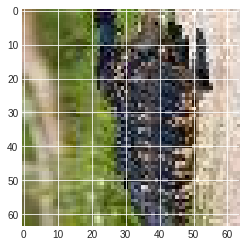

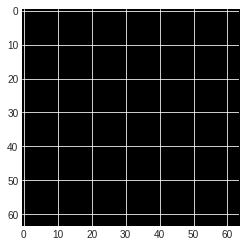

In [154]:
for i,x in enumerate(outliers):
    plot_torch_img(data_train[x][0])
    plt.show()

### Test

In [171]:
model = CNN()
model.load_state_dict(torch.load("models/CNN_1"))

X = torch.stack([data_test[i][0] for i in range(len(data_test))]).float()
Y = torch.stack([data_test[i][1] for i in range(len(data_test))]).float().detach().numpy().flatten()
pred = model(X).detach().numpy().flatten()
pred[pred>0.5] = 1
pred[pred<=0.5] = 0
print("Accuracy on the test set :",1-np.sum(np.abs(pred-Y))/len(Y))

Accuracy on the test set : 0.9116465863453815


### Test of the robustness

In [9]:
images = []
target = []
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            images.append(np.array(img)/255)
            target.append(i)
            
    i += 1

outliers = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers.append(np.array(img)/255)
        
images_train , images_test , target_train , target_test = train_test_split(images , target , random_state = random_seed)

In [ ]:
data_test = indexed_dataset.Dataset(images_test , torch.FloatTensor(target_test).view(-1,1) , transform = transformer)
history_MOM = []
history_class = []
outliers_2 = []
target_outliers_2 = []
bar = progressbar.progressbar

for i in range(200):
    outliers_2.append(rescale(np.random.normal(0, 1, images[i].shape)))
    target_outliers_2.append(randint(0,1))
    
for n_outliers in bar(range(1, 101, 10)):
    
    images_train_prime = images_train + outliers_2[:n_outliers]
    target_train_prime = target_train + target_outliers_2[:n_outliers]
    data_train = indexed_dataset.Dataset(images_train_prime , torch.FloatTensor(target_train_prime).view(-1,1) , transform = transformer)

    model_MOM = CNN()
    optimizer_MOM = torch.optim.Adam(model_MOM.parameters(), lr = 0.001)
    loss_MOM = torch.nn.modules.loss.BCEWithLogitsLoss(reduction = 'mean')
    MOM_CNN = MOM_training.mom_net(model_MOM, optimizer_MOM,
                                   loss_MOM, random_seed = random_seed,
                                   batch_size = 16, n_epochs = 250, n_hist = 0)
    MOM_CNN.fit(data_train, data_val = data_test, acc = True)
    

    model_classic = CNN()
    optimizer_classic = torch.optim.Adam( model_classic.parameters(), lr=0.001)
    loss_classic = torch.nn.modules.loss.BCEWithLogitsLoss(reduction = 'mean')
    classical_cnn = class_train.mom_net(model_classic , optimizer_classic,
                                        loss_classic, random_seed = random_seed,
                                        n_epochs = 100 , batch_size = 16, n_hist = 0)
    classical_cnn.fit(data_train, data_val = data_test, acc = True)

    
    history_MOM.append(MOM_CNN.history)
    history_class.append(classical_cnn.history)

In [22]:
MOM_dict = {}
class_dict = {}
for i in range(10):
    MOM_dict[i] = history_MOM[i]
    class_dict[i] = history_class[i]

In [23]:
import pickle
pickle.dump(MOM_dict, open( "momdico.p", "wb" ) )
pickle.dump(class_dict, open( "classdico.p", "wb" ) )

In [49]:
MOM_acc = []
MOM_loss = []
MOM_acc_bis = []
class_acc = []
class_loss = []
class_acc_bis = []

for i in range(10):
    MOM_acc.append(max(MOM_dict[i]['val_acc']))
    class_acc.append(max(class_dict[i]['val_acc']))
    MOM_loss.append(max(MOM_dict[i]['val_loss']))
    class_loss.append(max(class_dict[i]['val_loss']))
    MOM_acc_bis.append(MOM_dict[i]['val_acc'][-1])
    class_acc_bis.append(class_dict[i]['val_acc'][-1])

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


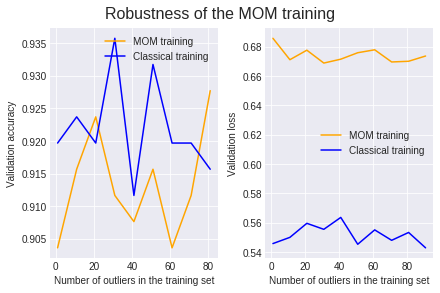

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Robustness of the MOM training", fontsize=16)

ax1.plot(list(range(1,91,10)), MOM_acc[:-1], color = 'orange', label = "MOM training")
ax1.plot(list(range(1,91,10)), class_acc[:-1], color = 'blue', label = "Classical training")
ax1.set_xlabel("Number of outliers in the training set")
ax1.set_ylabel("Validation accuracy")
ax1.legend()


ax2.plot(list(range(1,101,10)), MOM_loss, color = 'orange', label = "MOM training")
ax2.plot(list(range(1,101,10)), class_loss, color = 'blue', label = "Classical training")
ax2.set_xlabel("Number of outliers in the training set")
ax2.set_ylabel("Validation loss")
ax2.legend()

fig.show()
plt.savefig("robustness_deep.png")

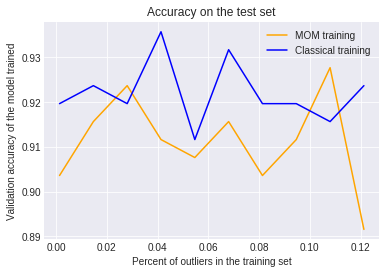

In [63]:
plt.plot(np.array(range(1,101,10))/750, MOM_acc, color = 'orange', label = "MOM training")
plt.plot(np.array(range(1,101,10))/750, class_acc, color = 'blue', label = "Classical training")
plt.xlabel("Percent of outliers in the training set")
plt.ylabel("Validation accuracy of the model trained")
plt.legend()
plt.title("Accuracy on the test set")
plt.savefig("robust_deep_2.png")